<a href="https://colab.research.google.com/github/q890003/Hybrid-image_Image-pyramid_Colorizing-the-Russian-Empire/blob/master/CV_hw2_2_Gaussian_Laplacian_Pyramid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

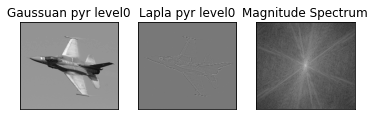

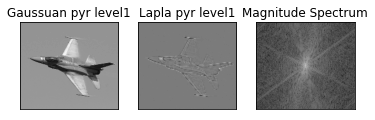

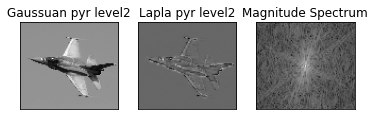

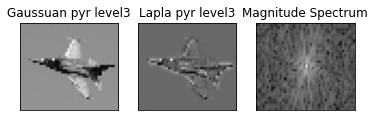

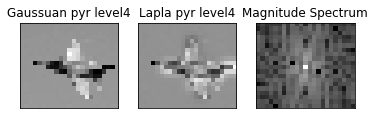

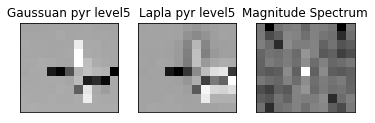

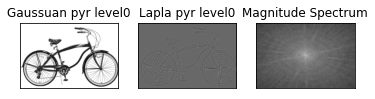

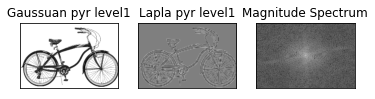

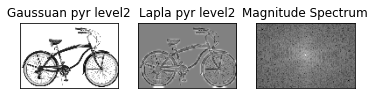

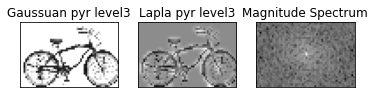

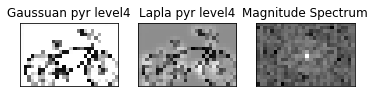

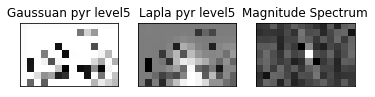

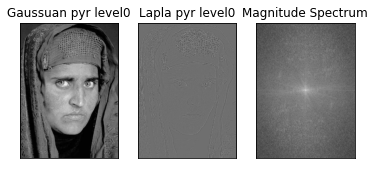

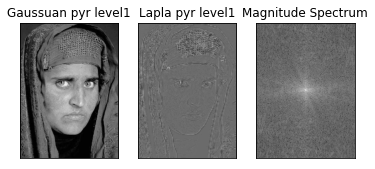

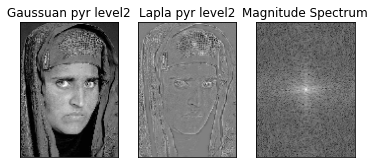

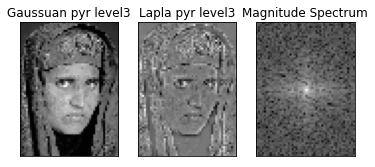

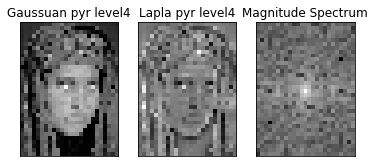

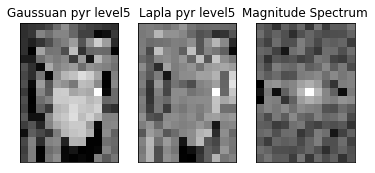

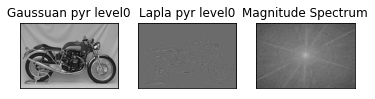

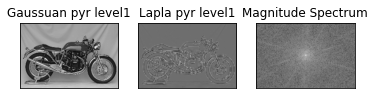

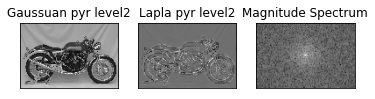

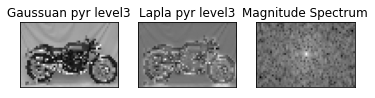

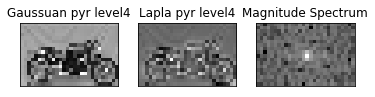

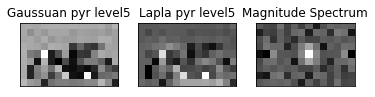

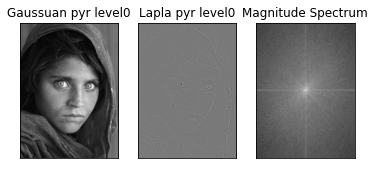

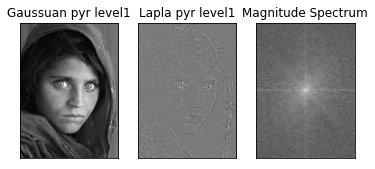

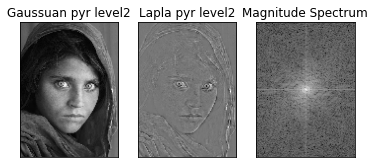

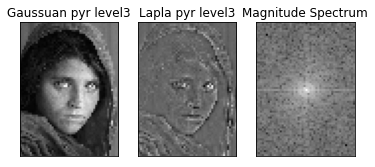

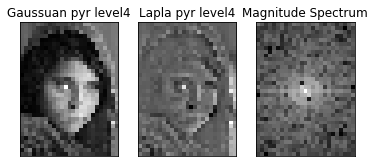

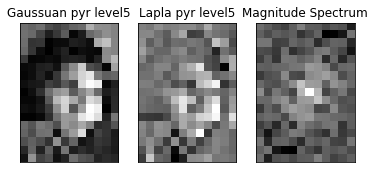

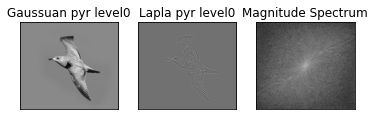

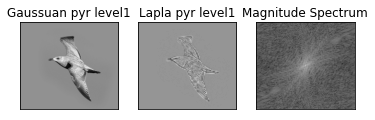

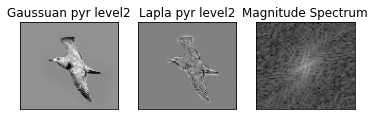

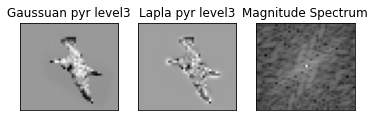

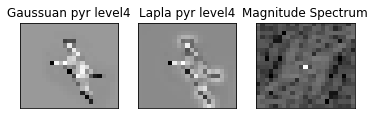

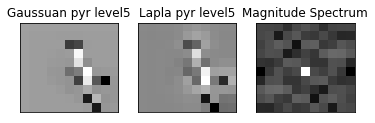

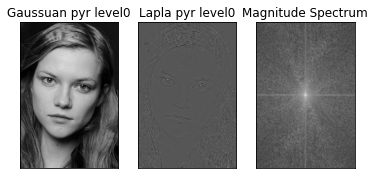

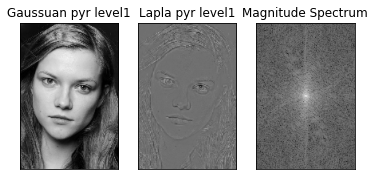

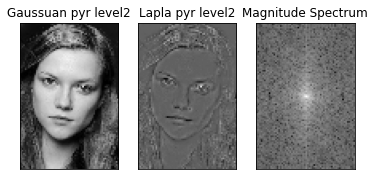

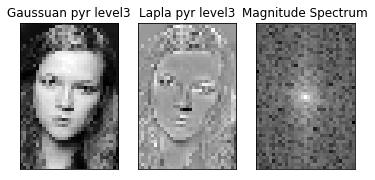

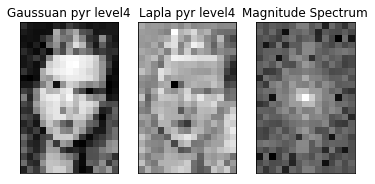

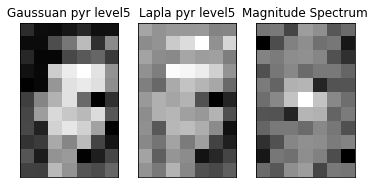

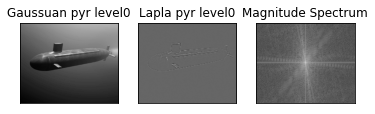

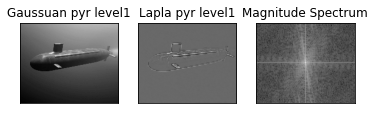

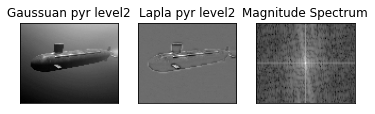

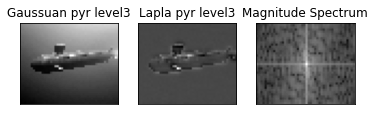

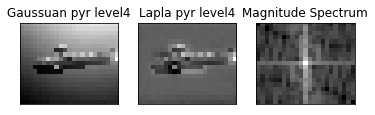

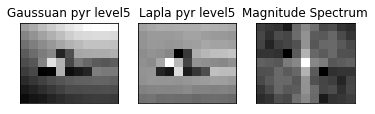

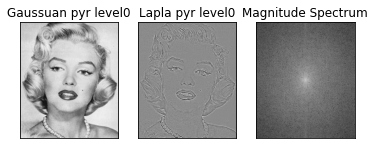

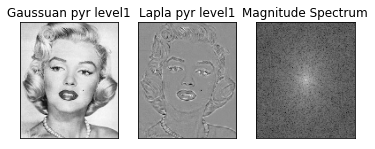

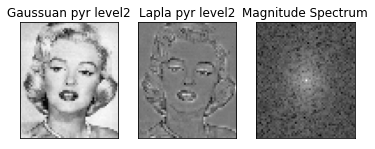

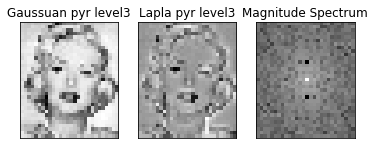

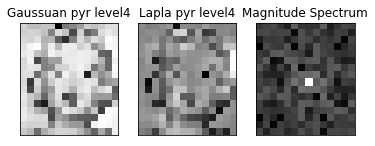

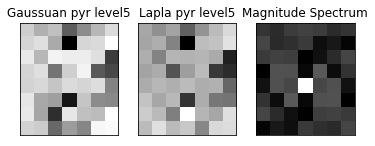

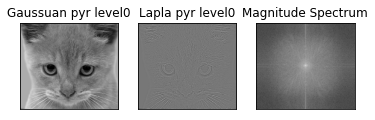

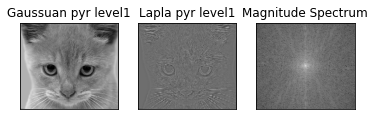

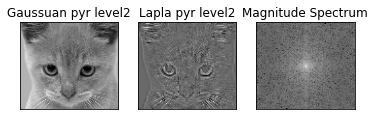

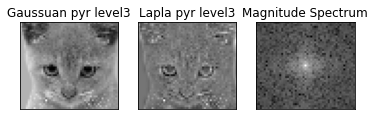

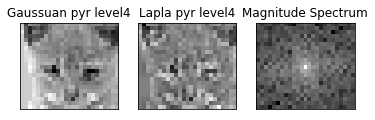

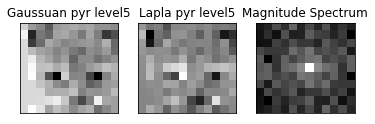

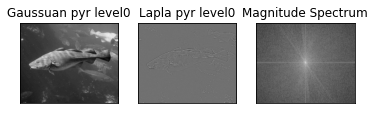

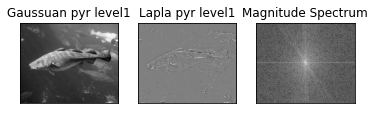

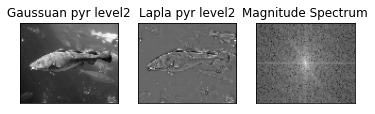

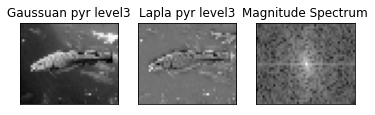

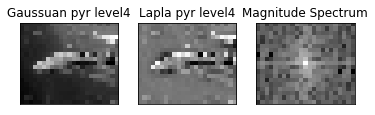

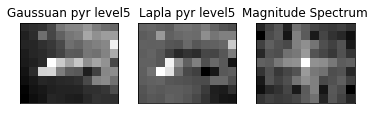

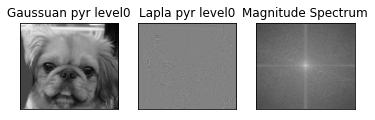

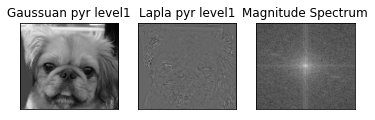

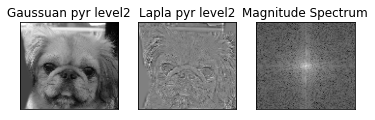

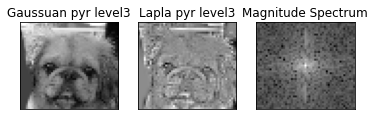

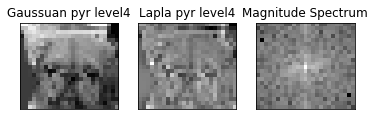

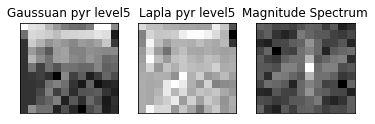

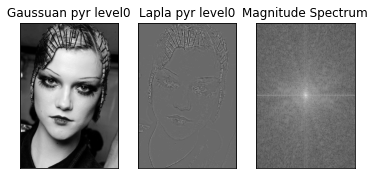

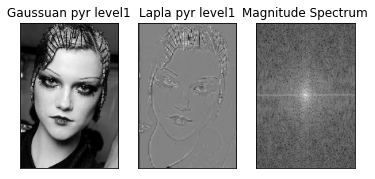

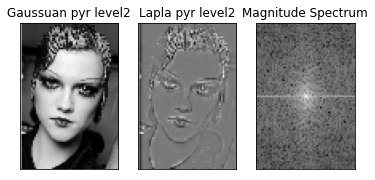

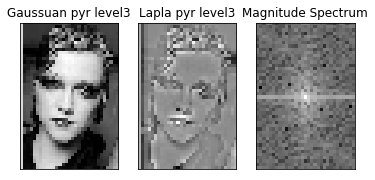

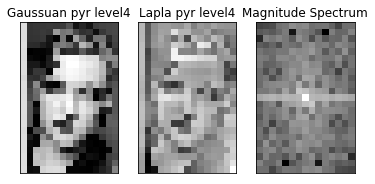

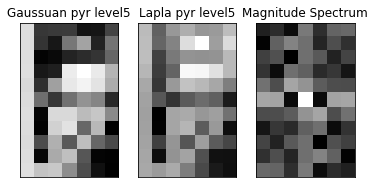

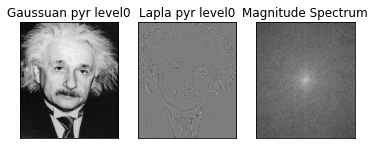

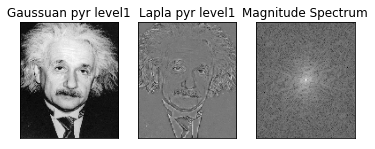

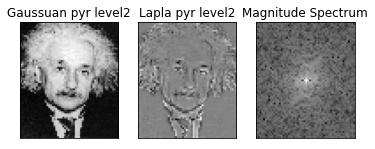

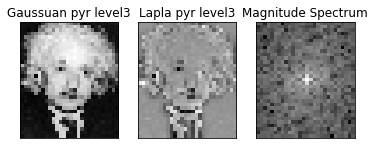

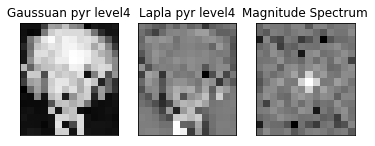

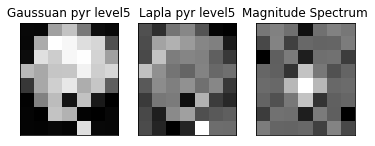

In [1]:
import numpy as np
import cv2 as cv 
import glob
import os
# import sys
from itertools import product
from matplotlib import pyplot as plt
def gaussian_filter(kersize, sigma):
    bdry = kersize//2
    x, y = np.mgrid[ -bdry:bdry+1, -bdry:bdry+1]
    gaussian_kernel = np.exp(-(x**2+y**2)) / ((2 * 3.1415926)**(0.5) * sigma)
    gaussian_kernel = gaussian_kernel / gaussian_kernel.sum()
    return gaussian_kernel

def gaussian_PyrSub(img):
    #convolution
    smooth_img = cv.filter2D(img, dst=-1, ddepth=-1, kernel=gaussian_filter(5, 3) , anchor=(-1, -1), delta=0, borderType=cv.BORDER_DEFAULT)
    #subsampling
    subsample_img = np.zeros((img.shape[0]//2, img.shape[1]//2),dtype=float)
    for (x, y) in product(range(0,img.shape[0]-1,2), range(0,img.shape[1]-1,2)):
        sub_x, sub_y = x>>1, y>>1
        subsample_img[sub_x, sub_y] = img[x,y]
    return subsample_img

def pyrUp(img):
    upsample_img = np.zeros((img.shape[0]*2, img.shape[1]*2))
    upsample_img[::2, ::2] = img[:,:]
    for (x, y) in product(range(0,upsample_img.shape[0],2), range(1,upsample_img.shape[1],2)):
        if y < upsample_img.shape[1] - 1:
            upsample_img[x,y] = (upsample_img[x,y-1] + upsample_img[x,y+1])/ 2
        else:
            upsample_img[x,y] = upsample_img[x,y-1]
    for (x, y) in product(range(1,upsample_img.shape[0],2), range(0,upsample_img.shape[1])):
        if x < upsample_img.shape[0] - 1:
            upsample_img[x,y] = (upsample_img[x-1,y] + upsample_img[x+1,y])/ 2
        else:
            upsample_img[x,y] = upsample_img[x-1,y]
    upsample_img = cv.filter2D(upsample_img, dst=-1, ddepth=-1, kernel=gaussian_filter(5, 0.4), anchor=(-1, -1), delta=0, borderType=cv.BORDER_DEFAULT)
    ####check 
    # plt.subplot(111),plt.imshow(upsample_img, cmap = 'gray')
    # plt.title('upsample_img'), plt.xticks([]), plt.yticks([])
    # plt.show()
    return upsample_img
    
def laplacian_Pyr(img, pyrUp_img):
    adj_row = img.shape[0] - pyrUp_img.shape[0]
    adj_col = img.shape[1] - pyrUp_img.shape[1]
    if adj_row < 0:
        pyrUp_img = np.delete(pyrUp_img, -1, 0)
    if adj_row > 0:
        pyrUp_img = np.append(pyrUp_img, [pyrUp_img[-1,:]], axis = 0)
    if adj_col < 0:
        pyrUp_img = np.delete(pyrUp_img, -1, 1)
    if adj_col > 0:
        pyrUp_img = np.append(pyrUp_img, pyrUp_img[:,-1].reshape(pyrUp_img.shape[0], 1), axis = 1)
    return img - pyrUp_img

# img = cv2.imread(sys.argv[1])
images = glob.glob('/content/drive/My Drive/Colab Notebooks/CV_hw2/data/*')
for img in images:
    G_pyr, L_pyr, spectrum= [], [], []
    (_ , filename) = os.path.split( img )
    filename, file_type = filename.split('.')

    img = cv.imread(img,0)
    G_pyr.append(img)
    for i in range(0, 6):
        #subsample
        subsample_img = gaussian_PyrSub(G_pyr[i])
        #magnitude_spectrum
        f = np.fft.fft2(G_pyr[i])
        fshift = np.fft.fftshift(f)
        magnitude_spectrum = 20*np.log(np.abs(fshift))
        spectrum.append(magnitude_spectrum)
        #Laplacian.  
        """
        formula: L_N = G_N                    , N is top of pyramid.
                 L_k = G_k - pyrUp( G_(k+1))  , k<N
        """
        Lapla = laplacian_Pyr(G_pyr[i], pyrUp(subsample_img))

        #record
        G_pyr.append(subsample_img)
        L_pyr.append(Lapla)
    
    for i in range(0,6):
        level_ith = str(i)
        plt.subplot(131),plt.imshow(G_pyr[i], cmap = 'gray')
        plt.title('Gaussuan pyr level' + level_ith), plt.xticks([]), plt.yticks([])
        plt.subplot(132),plt.imshow(L_pyr[i], cmap = 'gray')
        plt.title('Lapla pyr level' + level_ith), plt.xticks([]), plt.yticks([])
        plt.subplot(133),plt.imshow(spectrum[i], cmap = 'gray')
        plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
        plt.show()

        cv.imwrite('/content/drive/My Drive/Colab Notebooks/CV_hw2/output/'+filename +'_pyrLevel'+ level_ith + '.'+ file_type, G_pyr[i])
        